In [1]:
#importing libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
%load_ext autoreload
%autoreload 2

from data_gen_chng_bkg import *
from predict_info import *
from scipy.stats import poisson, norm

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix


from tensorflow.keras import backend as K
from sklearn.utils import shuffle

from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration



gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=7000)])
print(len(gpus), "Physical GPUs")   

2023-05-16 16:05:32.465774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-05-16 16:05:33.210554: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-16 16:05:33.211201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-16 16:05:33.245994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 16:05:33.246319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2023-05-16 16:05:33.246346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-16 16:05:33.247765: I tensorflow/stream_executor/platfo

In [8]:
X, y, df, X_clean, X_slope = data_gen_chng_bkg(N_data=50,
                                               N_tu=64,
                                               a=(-1,1),
                                               norm=True,
                                               x0=(8,56),
                                               w=(5,20),
                                               w_rat=(1,5),
                                               bkg=(50,300),
                                               SNR=(0.5,20),
                                              nu=(1,10),
                                              all_peak=False)
#data_gen_chng_bkg(N_data=100000,N_tu=256,x0=(64, 196),w=(5,20),w_rat=(0.1,2.5),A=(5,20),bkg=(5,15),a=(-0.03,0.03),norm=True):

/home/mchobola/diplo/data_gen_chng_bkg.py:13: RuntimeWarning: invalid value encountered in power
  y_peak = np.exp(-((x-x0)/w_d)**nu) * A
/home/mchobola/diplo/data_gen_chng_bkg.py:17: RuntimeWarning: invalid value encountered in power
  y_rise = np.exp(-((x0-x)/w_r)**nu) * A


In [6]:
X1, y1, df1, X_clean1, X_slope1 = data_gen_chng_bkg(N_data=1,
                                               N_tu=64,
                                               a=(0,0),
                                               norm=True,
                                               x0=(31,32),
                                               w=(5,5),
                                               w_rat=(1,1),
                                               bkg=(300,300),
                                               SNR=(9,10),
                                              nu=(2,2),
                                              all_peak=True)

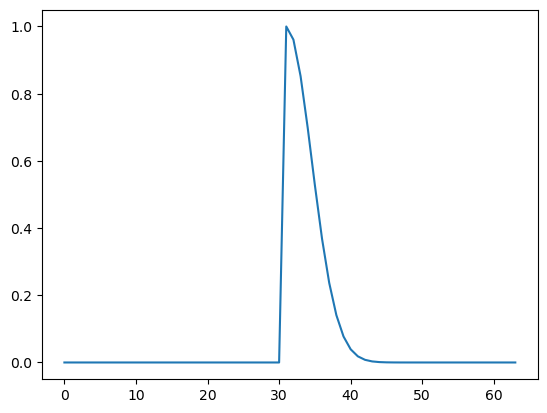

In [7]:
plt.plot(X_clean1[0])

In [9]:
df

x0     w_rat        w_r        w_d            A        SNR        nu  \
0   40  3.507031  23.422483   6.678722   118.315859   1.084432  6.552072   
1   22  3.593816  69.328089  19.290943   257.809341   1.210593  9.630012   
2   37  1.245882  19.250000  15.450904  2964.181667  11.826260  6.478508   
3   38  4.690001  31.321187   6.678291   228.246985   1.006157  9.787052   
4   21  4.607633  54.083309  11.737764   137.041954   1.500184  2.089145   
5   17  2.260965  36.757927  16.257629  2078.728185   9.998443  6.269374   
6   53  2.512819  31.965621  12.721021    36.169914   0.544956  5.818745   
7   22  3.396239  56.976626  16.776389  3712.772558  19.865967  8.992388   
8   13  4.032094  64.725107  16.052481   701.830453   2.362418  1.149672   
9   40  2.780062  29.940901  10.769868   196.383390   2.459419  3.912136   
10  17  4.951692  98.571599  19.906651   806.336521   6.662005  7.430236   
11  47  1.407530  18.729347  13.306531   182.928660   3.339053  9.583359   
12  54  1.075151   8.885591   8.264503   116.457526   0.625847  8.111694   
13  23  2.841861  15.790478   5.556387  2578.605069  19.704938  3.921095   
14  25  4.812668  37.251949   7.740394   643.844051   3.456915  6.755457   
15  51  2.868787  25.328192   8.828886   103.999752   0.651721  1.285446   
16  42  2.572620  18.127201   7.046201   596.228225   4.421841  9.604356   
17  13  2.025800  10.169592   5.020038   549.899446   1.974711  8.467385   
18  31  3.707730  20.916999   5.641456   343.259354   1.710680  3.123071   
19  13  1.208237  15.300839  12.663771   207.484075   0.714718  5.304149   
20  11  2.235773  35.187056  15.738205   678.317650   6.252223  2.936641   
21  35  4.742769  46.723265   9.851473   393.184254   2.111642  4.096150   
22  17  4.013011  57.975476  14.446875   315.246028   1.158477  7.550628   
23  45  2.905820  55.813887  19.207619   162.325069   1.298150  6.561270   
24  14  3.955773  60.540015  15.304218  2437.259619  13.172934  1.614850   
25  49  3.321867  50.153338  15.097938   315.270995   2.088548  9.742222   
26  26  2.594406  23.582793   9.089861   970.497034   4.481506  7.316046   
27  19  1.678874   8.414273   5.011856   157.010923   1.125444  8.017633   
28  30  2.093613  27.489518  13.130184   569.998321   2.918140  8.814600   
29  32  3.161537  26.159136   8.274183  1435.769466   7.743410  9.729733   
30  36  1.094683  17.043417  15.569268  2058.270453   8.164344  4.130532   
31  18  1.785686  17.402136   9.745349    32.970323   0.589700  2.002798   
32  35  1.380601  15.600452  11.299757   494.876565   2.059046  4.906334   
33  49  2.868452  15.684548   5.467948  1186.289477   5.406464  8.640086   
34  30  1.739183  28.303621  16.274090   768.206630  10.295564  5.158907   
35  55  3.190367  18.055564   5.659401   123.933960   0.558661  6.872277   
36  13  4.636545  85.413844  18.421871  2800.637822  13.313635  7.782580   
37  13  1.077884  15.414540  14.300741  1816.943335   7.075554  3.387530   
38  40  1.286311  23.055938  17.924084   734.044629   5.442546  9.339632   
39  37  1.366665  17.960816  13.142073   364.612956   1.624996  3.550478   
40  38  1.457376  23.180716  15.905789  3291.857561  13.501839  1.471482   
41  48  2.336305  38.764353  16.592160   335.238900   1.378837  9.140915   
42  46  3.191826  52.465867  16.437573   340.237584   2.695118  2.194929   
43  12  1.856357  26.824774  14.450227  3536.739836  19.689949  3.439058   
44  54  4.986352  83.106226  16.666737  1493.028058   6.122065  2.983958   
45  51  2.849394  29.615141  10.393487   427.541167   1.533728  4.851101   
46  15  4.232711  60.732423  14.348351   439.847885   1.497126  8.648611   
47  24  1.576922  16.644538  10.555079   143.158781   0.542713  9.876923   
48  10  1.771249  17.373234   9.808467  1602.794456  11.364957  5.509085   
49  55  2.747562  20.942431   7.622187   104.963230   0.752324  9.975239   

           bkg    GRB         a  
0   109.103990  False -0.286955  
1   212.961127  False -0.252059  
2   250.644055   True  0.

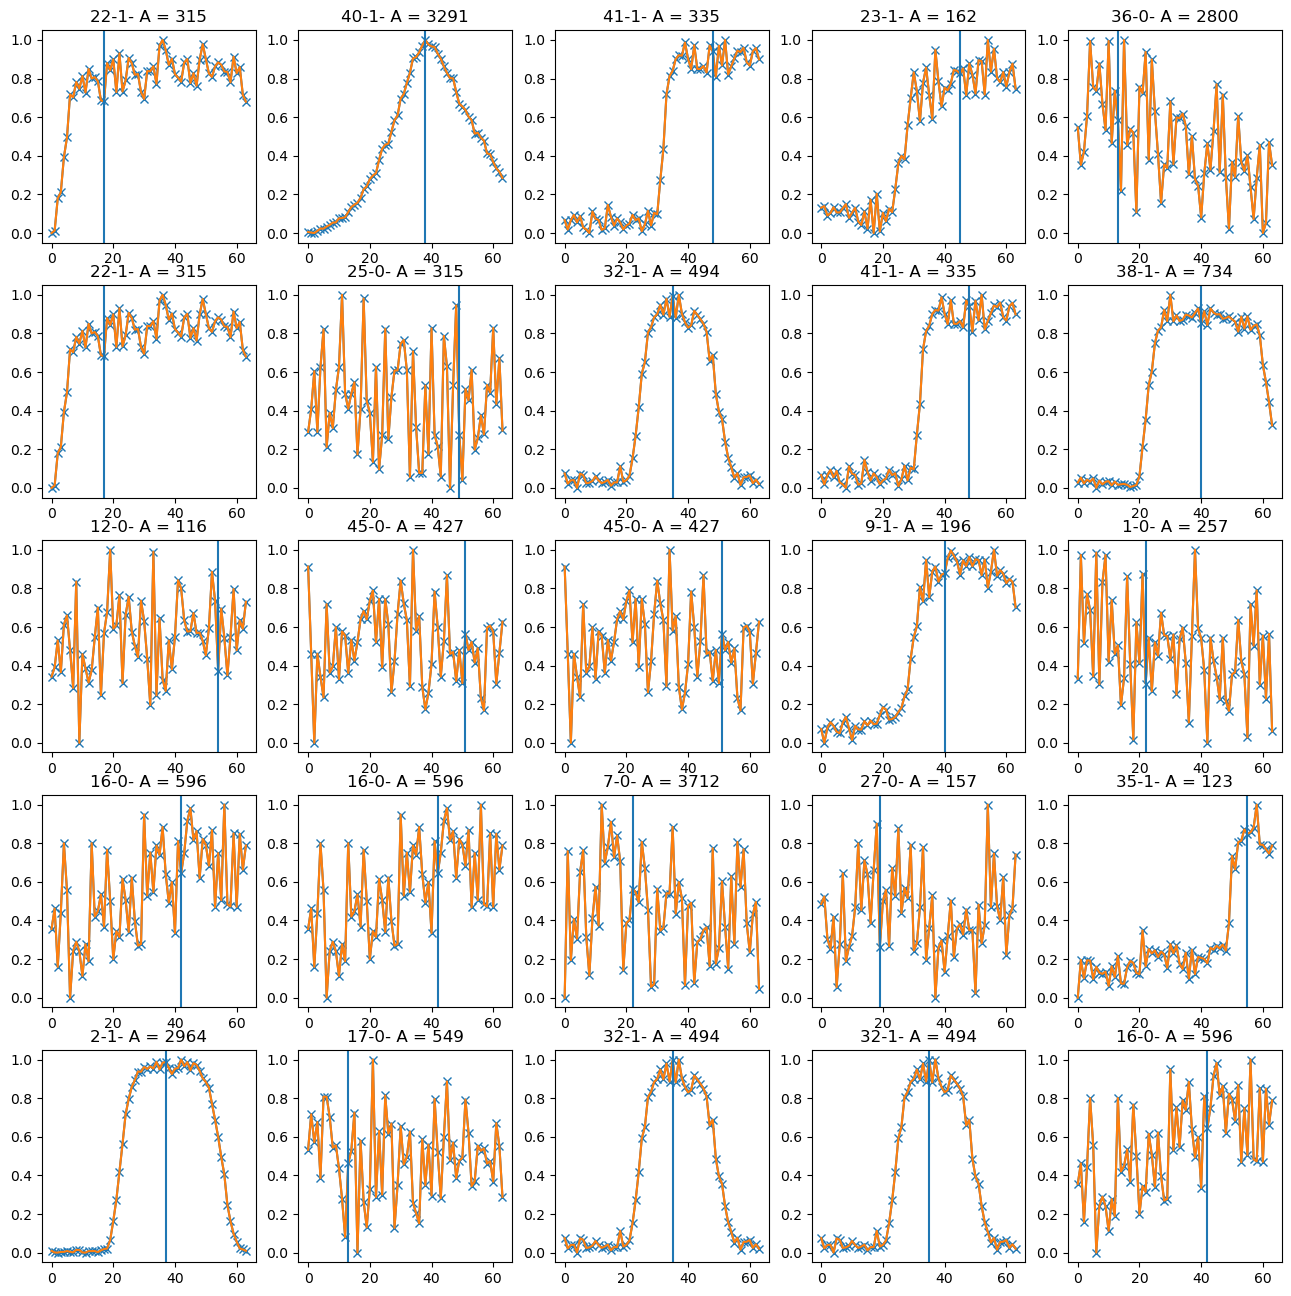

In [10]:
x = np.arange(len(X[0]))
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(X))
        cps = [entry for entry in X[ind]]
        axs[i,j].plot(x,cps, marker='x')
        axs[i,j].plot(cps)
        axs[i,j].axvline(df['x0'][ind])
        axs[i,j].set_title('{}-{}- A = {}'.format(ind,y[ind], int(df['A'][ind])))

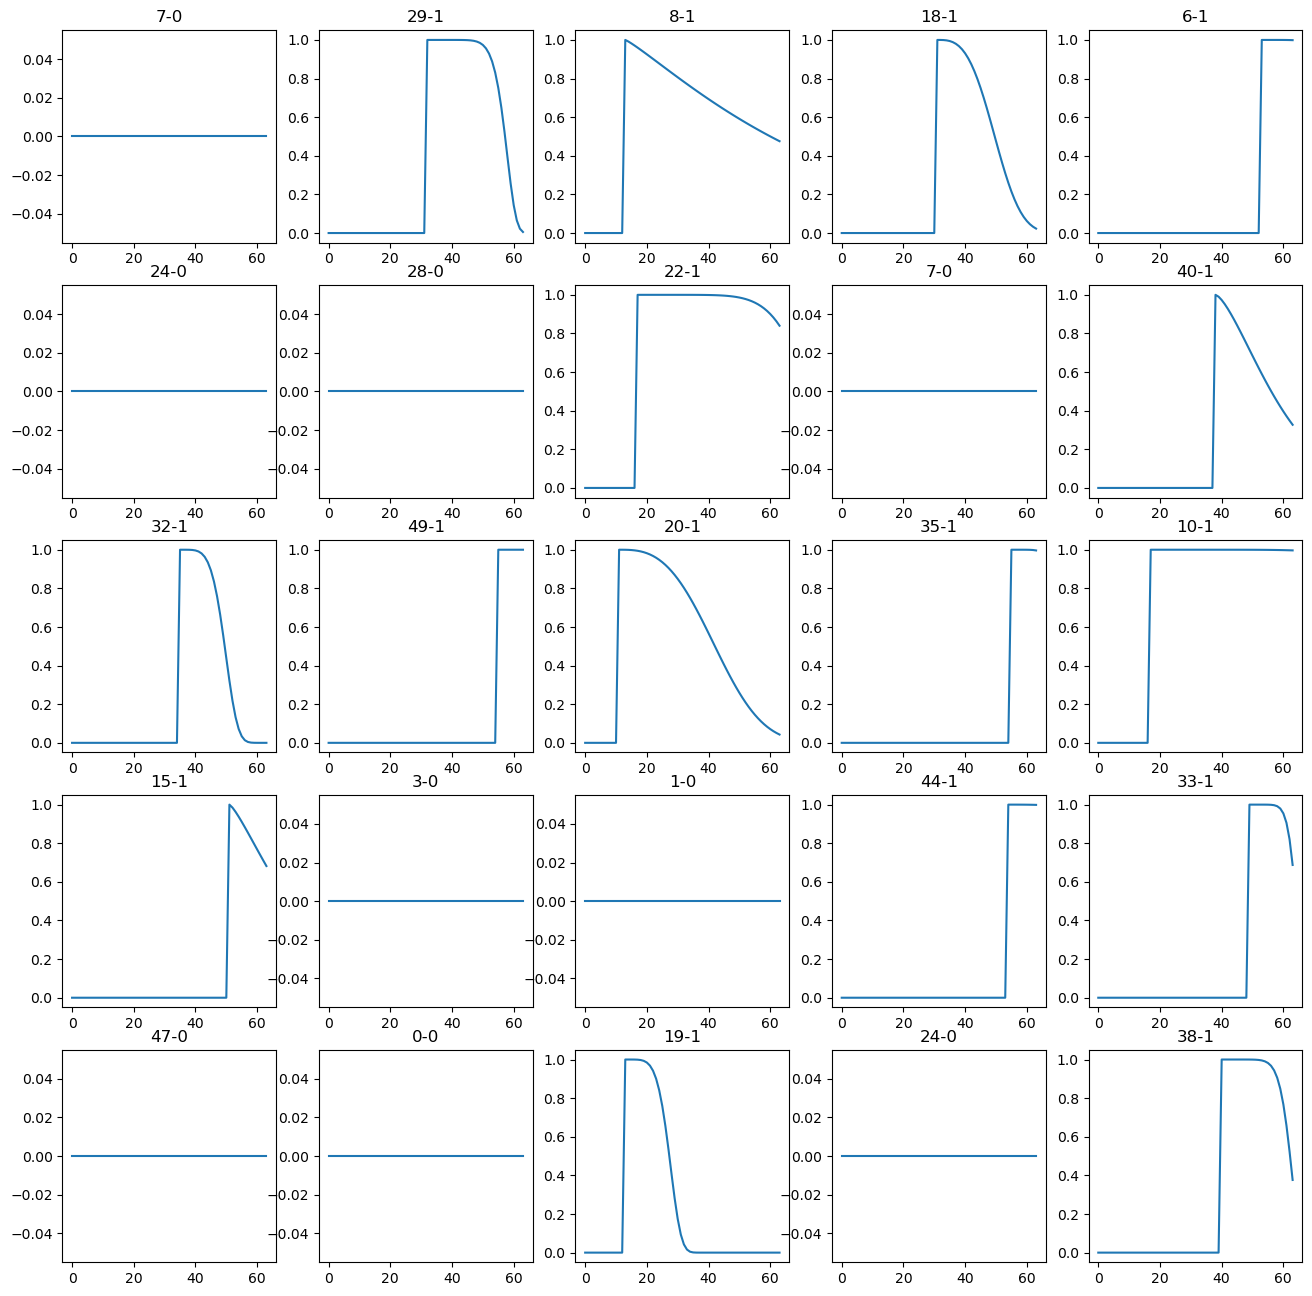

In [11]:
x = np.arange(len(X[0]))
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(X))
        cps = [entry for entry in X_clean[ind]]
        #axs[i,j].plot(x,cps, marker='x')
        axs[i,j].plot(cps)
        axs[i,j].set_title('{}-{}'.format(ind,y[ind]))

ValueError: operands could not be broadcast together with shapes (12,) (64,) 

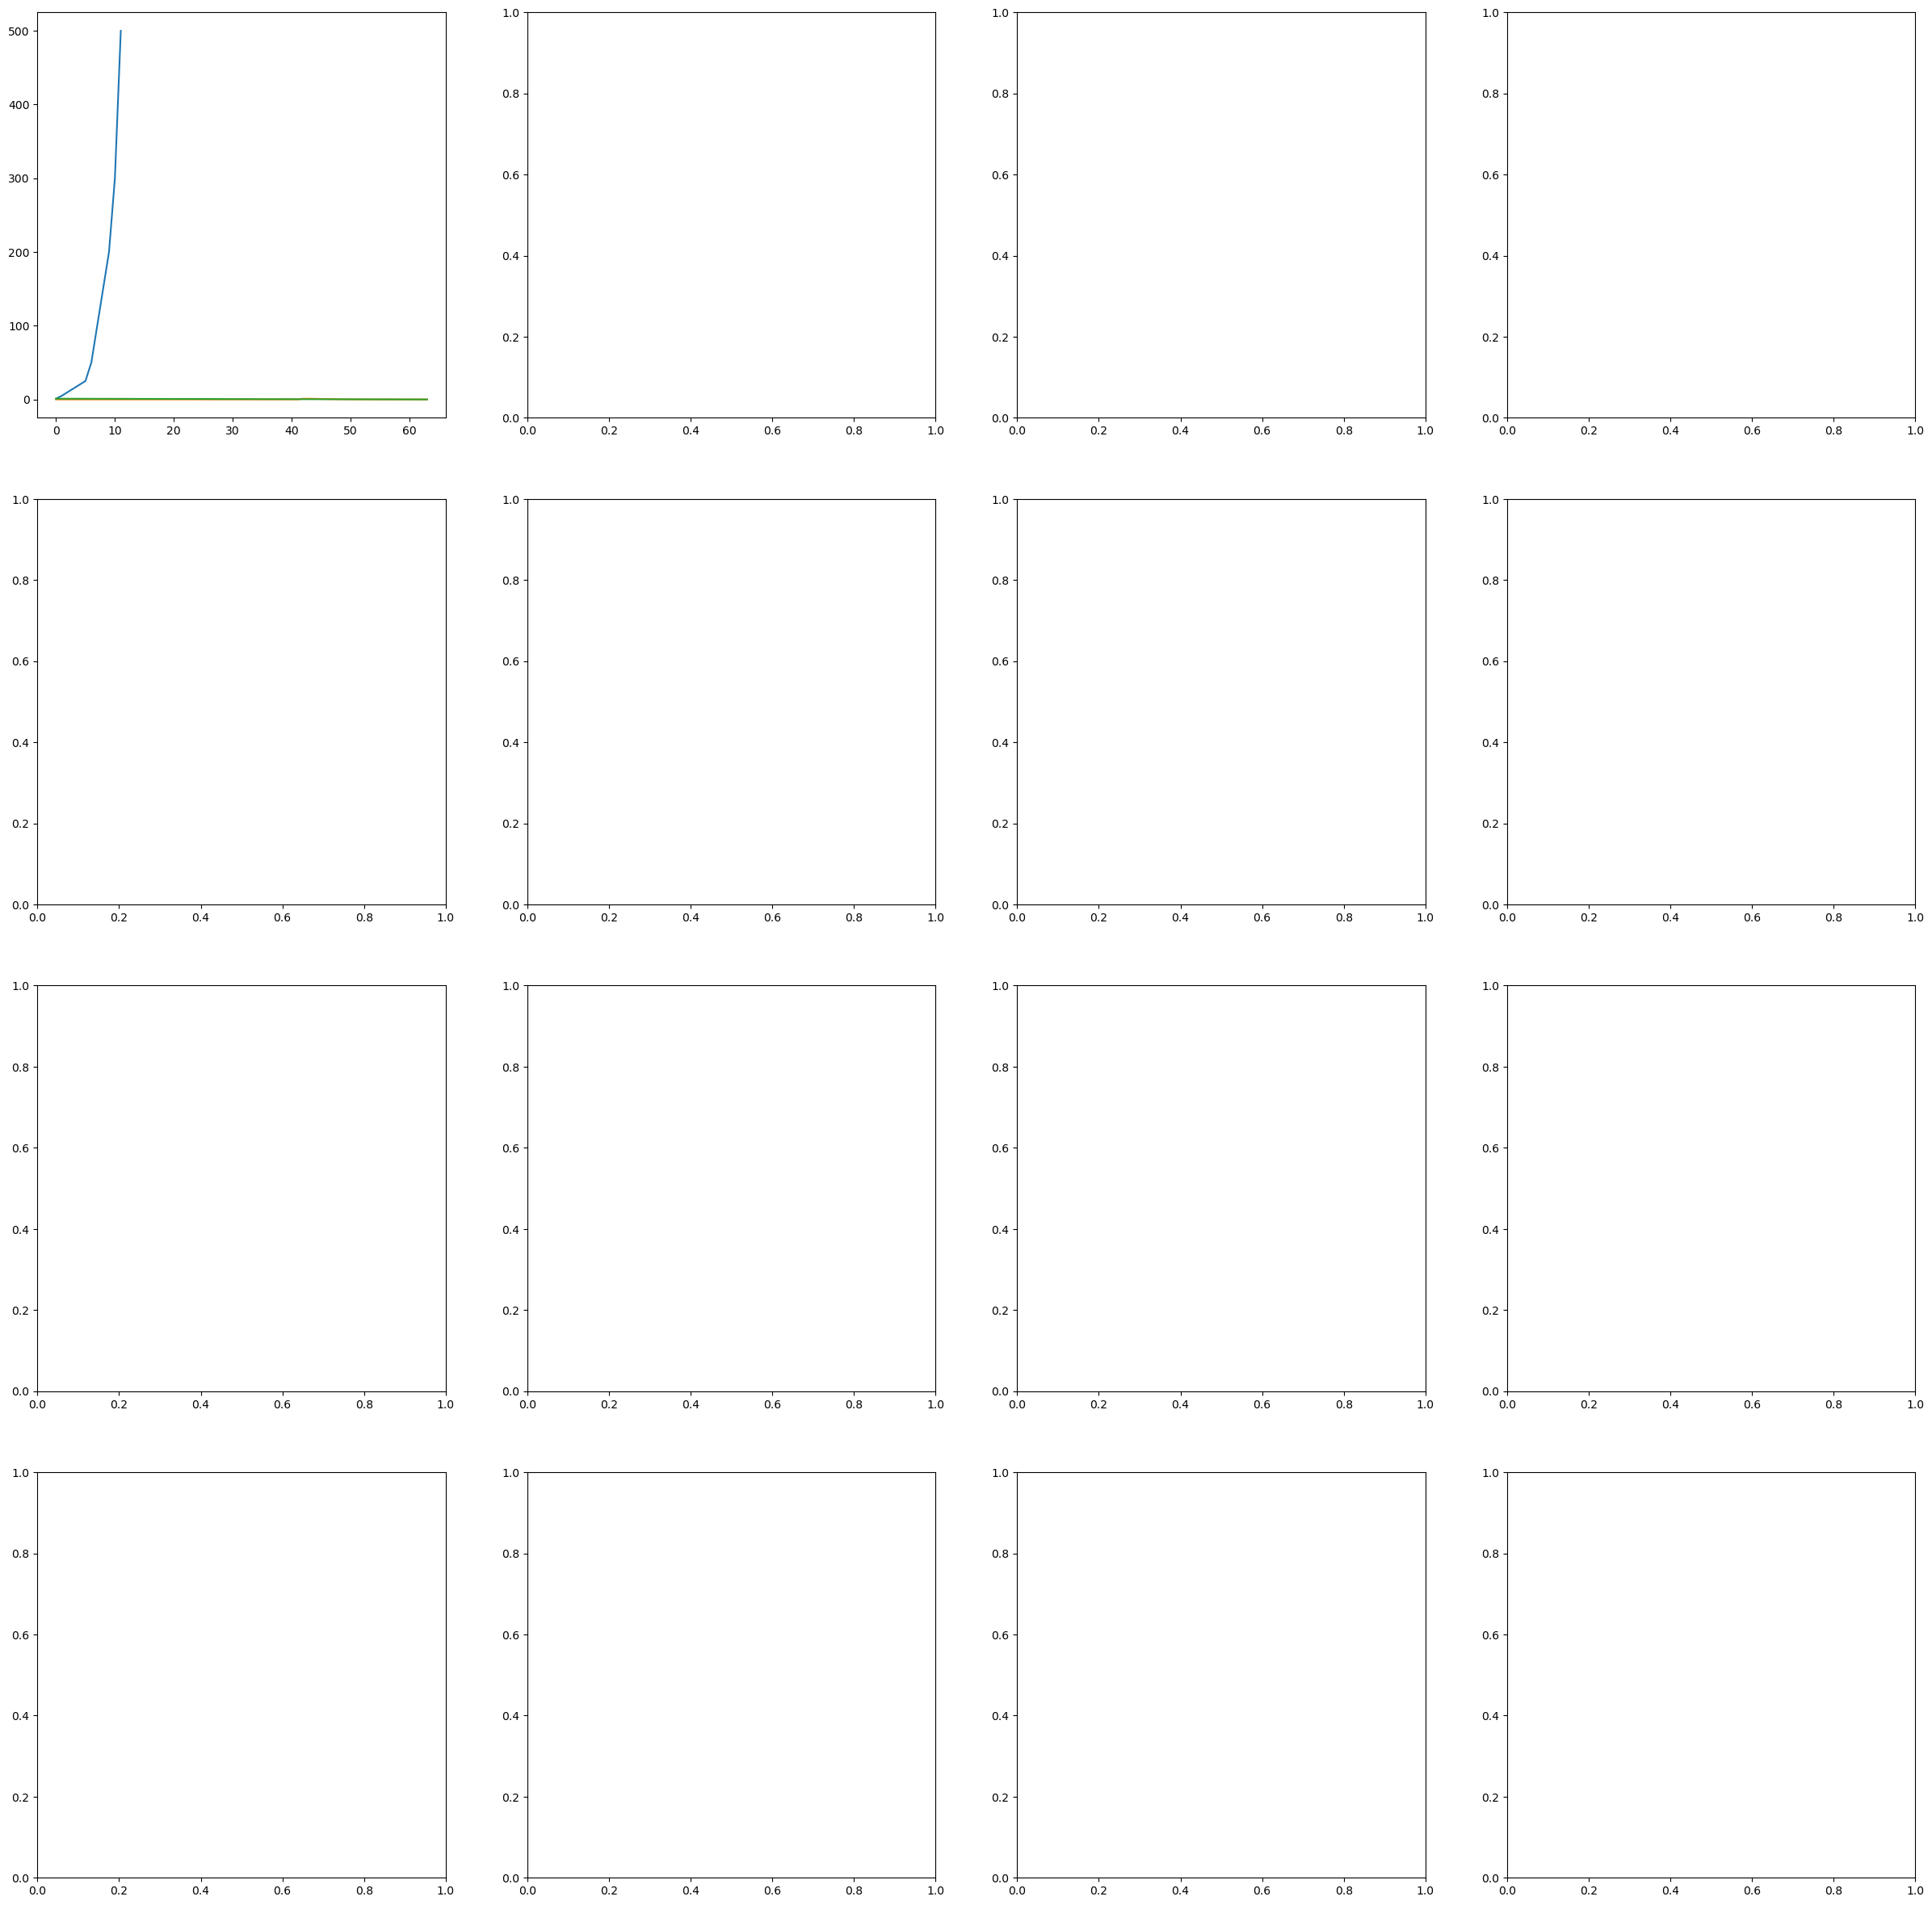

In [28]:
x = np.arange(len(X[0]))
fig, axs = plt.subplots(4,4,figsize=(30,30))

for i in range(4):
    for j in range(4):
        ind = np.random.randint(len(X))
        #axs[i,j].plot(x,cps, marker='x')
        axs[i,j].plot(X[ind], label='LC')
        axs[i,j].plot(X_clean[ind], label='GRB (if any)')
        axs[i,j].plot(X_slope[ind], label='Trend')
        axs[i,j].plot(X[ind]-X_clean[ind],label='LC-GRB')
        axs[i,j].plot(X[ind]-X_slope[ind]-X_clean[ind],label='Noise')
        axs[i,j].legend(loc='upper left')
        axs[i,j].set_title('{}-{}- A = {}'.format(ind,y[ind], int(df['A'][ind])))

## Simulated data preprocessing for training

In [7]:
X = np.array(X).reshape(-1, 64, 1).astype(np.float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)


#  Conv1D

In [9]:
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=(64,1)))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 64)             12352     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1

2023-05-16 14:15:31.400978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:15:31.401313: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-16 14:15:31.401490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 14:15:31.401820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 46

In [10]:
fileName = '{}-{}-{}-{}'.format(datetime.datetime.today().month,
          datetime.datetime.today().day,
          datetime.datetime.today().hour,
          datetime.datetime.today().minute)

In [11]:
callback = [ModelCheckpoint("models/classConv_{}.h5".format(fileName), 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True, 
                             mode='min'),
           TensorBoard(log_dir='Tensor_logs/class_conv/{}'.format(fileName)),
           ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=True,min_lr=0.000001),
           EarlyStopping(monitor='val_loss', patience=9)]

2023-05-16 14:15:32.131897: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-16 14:15:32.131918: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-16 14:15:32.131946: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-16 14:15:32.132557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-16 14:15:32.232886: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-16 14:15:32.233093: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [12]:
history_conv = model.fit(X_train, y_train,
          validation_data = (X_test, y_test), epochs=150, callbacks=[callback])

Epoch 1/150


2023-05-16 14:15:32.273246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-16 14:15:32.290181: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-05-16 14:15:32.752978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-16 14:15:32.919834: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


 100/1172 [=>............................] - ETA: 2s - loss: 0.6297 - accuracy: 0.5940

2023-05-16 14:15:33.835224: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-16 14:15:33.835248: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-16 14:15:33.835835: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-16 14:15:33.839593: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-16 14:15:33.840395: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-16 14:15:33.840890: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-16 14:15:33.841889: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Tensor_logs/class_conv/5-16-14-15/train/pl

1172/1172 [==============================] - 5s 3ms/step - loss: 0.4140 - accuracy: 0.8760 - val_loss: 0.2056 - val_accuracy: 0.9806

Epoch 00001: val_loss improved from inf to 0.20559, saving model to models/classConv_5-16-14-15.h5
Epoch 2/150
1172/1172 [==============================] - 3s 2ms/step - loss: 0.1685 - accuracy: 0.9826 - val_loss: 0.1094 - val_accuracy: 0.9885

Epoch 00002: val_loss improved from 0.20559 to 0.10943, saving model to models/classConv_5-16-14-15.h5
Epoch 3/150
1172/1172 [==============================] - 3s 2ms/step - loss: 0.1055 - accuracy: 0.9856 - val_loss: 0.0770 - val_accuracy: 0.9879

Epoch 00003: val_loss improved from 0.10943 to 0.07696, saving model to models/classConv_5-16-14-15.h5
Epoch 4/150
1172/1172 [==============================] - 3s 2ms/step - loss: 0.0721 - accuracy: 0.9877 - val_loss: 0.0575 - val_accuracy: 0.9885

Epoch 00004: val_loss improved from 0.07696 to 0.05751, saving model to models/classConv_5-16-14-15.h5
Epoch 5/150
1172/117

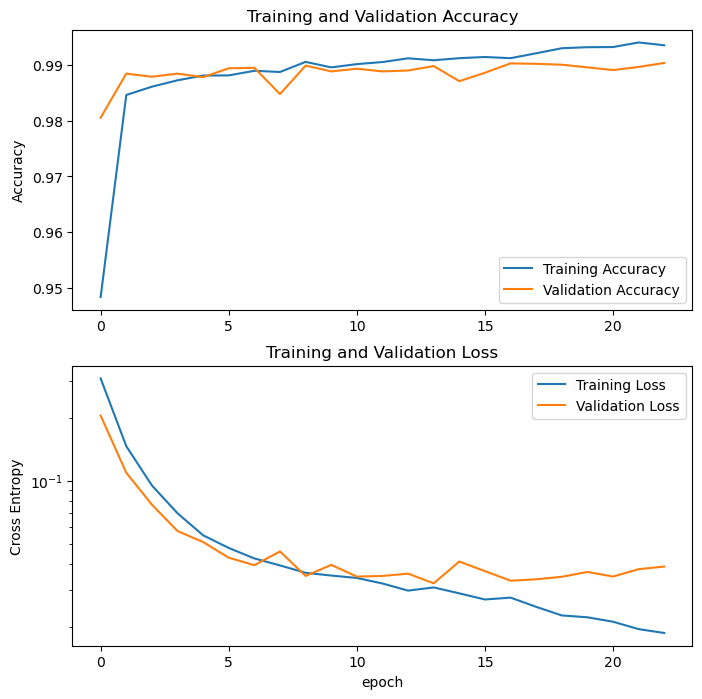

In [13]:
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

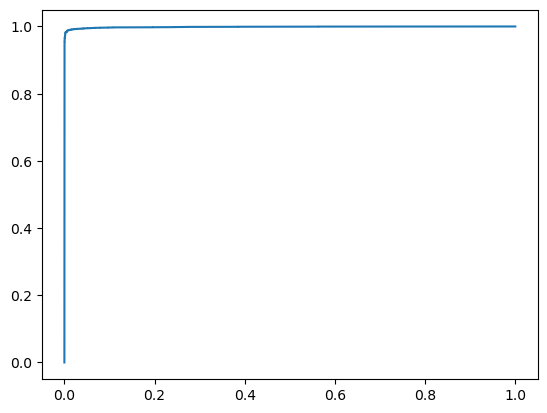

In [14]:
#ROC curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)

True Negatives:  6170
False Positives:  43
False Negatives:  77
True Positives:  6210
Total:  12500


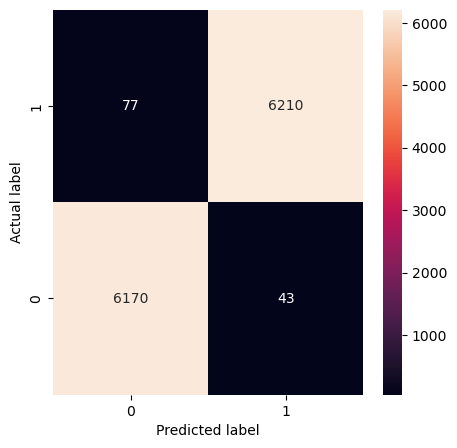

In [15]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions >= p)
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(cm, annot=True, fmt="d")
    ax.invert_yaxis()
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm))
plot_cm(y_test, y_pred_keras)

(array([6139.,   46.,   30.,   16.,   16.,   15.,   12.,   14.,   23.,
        6189.]),
 array([4.63497187e-08, 9.98013318e-02, 1.99602619e-01, 2.99403906e-01,
        3.99205178e-01, 4.99006480e-01, 5.98807752e-01, 6.98609054e-01,
        7.98410356e-01, 8.98211598e-01, 9.98012900e-01]),
 <BarContainer object of 10 artists>)

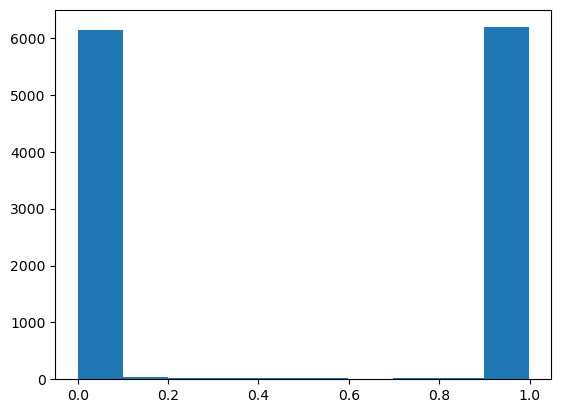

In [16]:
plt.hist(y_pred_keras)

In [17]:
#model.save("conv1d_model")

True Negatives:  6170
False Positives:  43
False Negatives:  77
True Positives:  6210
Total:  12500
True / False - 12380 / 120 - 99.04 / 0.96


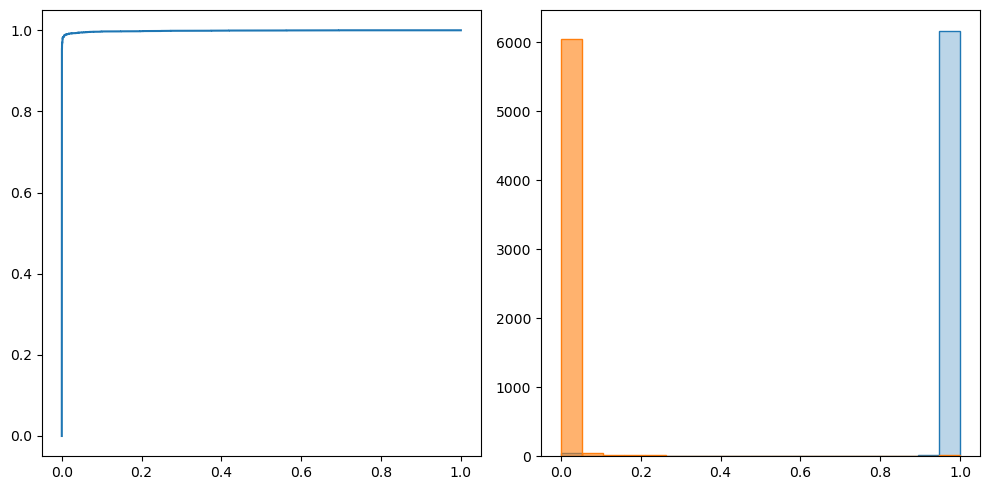

In [18]:
predict_graph_info(y_test, y_pred_keras)

In [19]:
def pred_SN_ratio(autoencoder,all_peak=True, N=100):
    predikce_A = {}
    bkg_list = [1,5,10,15,20,25,50,100,150,200,300,500]
    A_list = [1,5,10,15,20,25,50,100,150,200,300,500]
    for A in A_list:
        for bkg in bkg_list:
            ehm = []
            for i in range(N):
                lc_max_A = data_gen_chng_bkg(N_data=1,N_tu=64,x0=(16, 48),w=(5,20),w_rat=(0.1,2.5),A=(A,A),nu=(1,5),bkg=(bkg,bkg),a=(-0.03,0.03),norm=True,all_peak=all_peak)
                #print(lc_max_A[0][0])
                y_pred_max_A = autoencoder.predict(np.array(lc_max_A[0][0]).reshape(-1, 64, 1).astype(np.float32))
                #print(y_pred_max_A)
                y_pred_max_A = np.where(y_pred_max_A <= 0.5, 0, 1)
                #print(y_pred_max_A)
                ehm.append(bool(y_pred_max_A))
                #print(ehm)
            predikce_A[A,bkg] = ehm
    return predikce_A
predik = pred_SN_ratio(model,all_peak=True)

/home/mchobola/diplo/data_gen_chng_bkg.py:12: RuntimeWarning: invalid value encountered in power
  y_peak = np.exp(-((x-x0)/w_d)**nu) * A
/home/mchobola/diplo/data_gen_chng_bkg.py:16: RuntimeWarning: invalid value encountered in power
  y_rise = np.exp(-((x0-x)/w_r)**nu) * A


{(1, 1): [True,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False],
 (1, 5): [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,


In [45]:
def pred_falus(autoencoder,all_peak=True, N=100):
    SNR = np.logspace(np.log10(0.1),np.log10(500),10)
    predikce_A = np.empty((len(SNR),N))
    for n,snr in enumerate(SNR):
        ehm = []
        for i in range(N):
            
            bkg = np.random.uniform(50,300)
            A = bkg * snr
            print(bkg,A)
            lc_max_A = data_gen_chng_bkg(N_data=1,N_tu=64,x0=(16, 48),w=(5,20),w_rat=(0.1,2.5),A=(A,A),nu=(1,5),bkg=(bkg,bkg),a=(-0.03,0.03),norm=True,all_peak=all_peak)
            #print(lc_max_A[0][0])
            y_pred_max_A = autoencoder.predict(np.array(lc_max_A[0][0]).reshape(-1, 64, 1).astype(np.float32))
            #print(y_pred_max_A)
            #y_pred_max_A = np.where(y_pred_max_A <= 0.5, 0, 1)
            #print(y_pred_max_A)
            #ehm.append(y_pred_max_A)
            #print(ehm)
            predikce_A[n,i] = y_pred_max_A
    return predikce_A
predik = pred_falus(model,all_peak=True)

283.8807166531061 28.388071665310612
132.1648163320043 13.21648163320043
62.196101411796334 6.219610141179634
238.96295516544055 23.896295516544058
80.49510990817313 8.049510990817314
264.07860081877936 26.40786008187794
262.6531533214172 26.265315332141725
72.16415148973269 7.216415148973269
139.71272133614846 13.971272133614846
218.27718324412413 21.827718324412416
152.3058271110836 15.230582711108362
54.81010316238317 5.481010316238318
114.48369595030564 11.448369595030565
199.1570774494979 19.915707744949792
140.55078747051695 14.055078747051695
162.65201122990646 16.265201122990646
84.98915079045543 8.498915079045544
142.15185380158644 14.215185380158644
76.06941771741333 7.606941771741333
293.9324193900936 29.393241939009364
237.58191224025805 23.758191224025808
119.91900111209004 11.991900111209006
171.24631437411574 17.124631437411576
108.54463124713905 10.854463124713906
276.19621434856685 27.619621434856686
102.27664459954096 10.227664459954097
215.5088363138694 21.5508836313

In [46]:
predik

array([[9.80285764e-01, 9.20238018e-01, 9.39170063e-01, 5.84259808e-01,
        1.04148767e-03, 2.72984803e-01, 9.95375991e-01, 9.16058719e-01,
        6.28018737e-01, 6.58258080e-01, 3.59449565e-01, 4.12986934e-01,
        9.34363365e-01, 6.19368479e-02, 5.12604892e-01, 1.79198505e-05,
        3.93815862e-05, 1.24021433e-04, 5.99462692e-05, 9.74448740e-01,
        9.86471474e-01, 1.32385030e-01, 9.31366812e-03, 3.41509476e-05,
        9.98012900e-01, 1.88209196e-05, 9.93311048e-01, 3.26162735e-05,
        9.05296624e-01, 3.31948220e-04, 1.03115985e-04, 1.17503582e-02,
        8.42478752e-01, 6.23597181e-04, 8.10158090e-04, 9.94374275e-01,
        8.29648137e-01, 9.33175325e-01, 1.23775995e-03, 3.35420575e-03,
        6.53089762e-01, 3.26387584e-02, 8.53635938e-05, 5.18161221e-04,
        7.59765357e-02, 2.47684136e-01, 7.52313156e-03, 9.74784017e-01,
        5.66299856e-01, 2.30419543e-03, 5.01169241e-04, 5.34666795e-03,
        2.55440042e-04, 9.58495017e-04, 1.73302546e-01, 1.452621

In [38]:
def pred_bkg(autoencoder, N=100):
    predikce_bkg = {}
    bkg_list = [1,5,10,15,20,25,50,100,150,200,300,500]
    for bkg in bkg_list:
        ehm = []
        for i in range(N):
            lc_max_A = data_gen_chng_bkg(N_data=1,N_tu=64,x0=(8, 56),w=(5,20),w_rat=(0.1,5),A=(10,300),nu=(1,5),bkg=(bkg,bkg),a=(-0.03,0.03),norm=True,all_peak=False) # opravit na all bkg
            y_pred_max_A = autoencoder.predict(np.array(lc_max_A[0][0]).reshape(-1, 64, 1).astype(np.float32))
            ehm.append(y_pred_max_A[0])
        predikce_bkg[bkg] = ehm
    return predikce_bkg
pred_bkkg = pred_bkg(model,N=10)

/home/mchobola/diplo/data_gen_chng_bkg.py:12: RuntimeWarning: invalid value encountered in power
  y_peak = np.exp(-((x-x0)/w_d)**nu) * A
/home/mchobola/diplo/data_gen_chng_bkg.py:16: RuntimeWarning: invalid value encountered in power
  y_rise = np.exp(-((x0-x)/w_r)**nu) * A


In [39]:
pred_bkkg

{1: [array([0.00102648], dtype=float32),
  array([0.00272438], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.00160662], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  array([3.864437e-05], dtype=float32),
  array([0.9980129], dtype=float32)],
 5: [array([0.9980129], dtype=float32),
  array([0.00010608], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  array([4.7114347e-05], dtype=float32),
  array([6.176706e-05], dtype=float32),
  array([0.00037596], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.00329089], dtype=float32)],
 10: [array([0.00294408], dtype=float32),
  array([0.00041946], dtype=float32),
  array([0.00022462], dtype=float32),
  array([0.00090081], dtype=float32),
  array([0.9980129], dtype=float32),
  array([0.9980129], dtype=float32),
  arra

In [20]:
true_counts = {}

for key, statements in predik.items():
    true_count = sum(statements)
    true_counts[key] = true_count

print(true_counts)

{(1, 1): 25, (1, 5): 2, (1, 10): 1, (1, 15): 0, (1, 20): 2, (1, 25): 1, (1, 50): 2, (1, 100): 0, (1, 150): 1, (1, 200): 0, (1, 300): 1, (1, 500): 2, (5, 1): 88, (5, 5): 64, (5, 10): 31, (5, 15): 32, (5, 20): 16, (5, 25): 18, (5, 50): 6, (5, 100): 3, (5, 150): 0, (5, 200): 1, (5, 300): 0, (5, 500): 1, (10, 1): 100, (10, 5): 97, (10, 10): 91, (10, 15): 78, (10, 20): 80, (10, 25): 66, (10, 50): 32, (10, 100): 13, (10, 150): 5, (10, 200): 1, (10, 300): 2, (10, 500): 1, (15, 1): 100, (15, 5): 100, (15, 10): 97, (15, 15): 98, (15, 20): 95, (15, 25): 89, (15, 50): 72, (15, 100): 33, (15, 150): 25, (15, 200): 19, (15, 300): 8, (15, 500): 3, (20, 1): 100, (20, 5): 100, (20, 10): 100, (20, 15): 100, (20, 20): 100, (20, 25): 98, (20, 50): 94, (20, 100): 67, (20, 150): 36, (20, 200): 37, (20, 300): 21, (20, 500): 12, (25, 1): 100, (25, 5): 100, (25, 10): 100, (25, 15): 99, (25, 20): 100, (25, 25): 100, (25, 50): 97, (25, 100): 80, (25, 150): 69, (25, 200): 57, (25, 300): 42, (25, 500): 18, (50, 1)

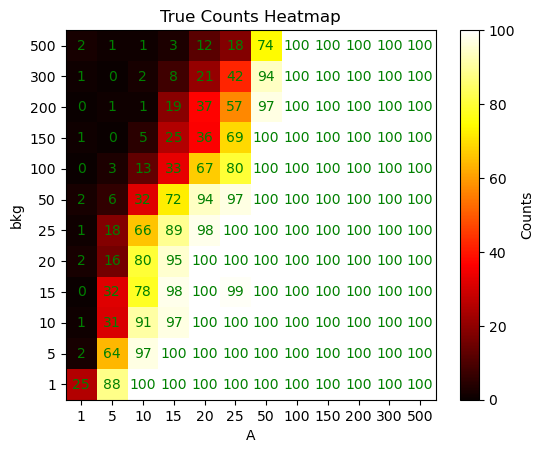

In [21]:
# Extract the x and y values from the dictionary keys
x_values = [key[0] for key in true_counts.keys()]
y_values = [key[1] for key in true_counts.keys()]

# Extract the count values from the dictionary values
count_values = list(true_counts.values())

# Create a list of unique x and y values
unique_x = sorted(set(x_values))
unique_y = sorted(set(y_values), reverse=True)

# Create a 2D grid of x and y values
X_a, Y_a = np.meshgrid(unique_x, unique_y)

# Create a list of count values corresponding to the grid
Z = np.zeros_like(X_a)
for (x_a, y_a), count in true_counts.items():
    idx = np.where((X_a == x_a) & (Y_a == y_a))
    Z[idx] = count

# Create a heatmap using Matplotlib
plt.imshow(Z, cmap='hot', interpolation='nearest')
plt.colorbar(label='Counts')
plt.xlabel('A')
plt.ylabel('bkg')
plt.xticks(range(len(unique_x)), unique_x)
plt.yticks(range(len(unique_y)), unique_y)
plt.title('True Counts Heatmap')

# Add the count values to each square
for i in range(len(unique_y)):
    for j in range(len(unique_x)):
        plt.text(j, i, Z[i, j], ha='center', va='center', color='green')

plt.show()

In [22]:
def isModelGood(model,windowSize):
    grbs = glob.glob("Data/scaled_xyz_128_64/*.csv")
    n_grbs = len(grbs)
    #fig, axs = plt.subplots(n_grbs,5,figsize=(30,3*n_grbs))
    pred, true_nonnorm, true_norm = [[] for i in range(n_grbs)],[], [[] for i in range(n_grbs)]
    for n , grb in enumerate(grbs):
        df = pd.read_csv(grb, index_col=0)
        true_nonnorm.append(df['4'].to_numpy())
        df = df.drop(['0'],axis=1)
        df['4'] = (df['4']-min(df['4']))/(max(df['4'])- min(df['4']))
        num_df = df.to_numpy()
        true_norm[n].append(num_df[:,-1])
        for i in range(len(num_df)-windowSize):
            X0 = num_df[i:i+windowSize,-1]
            pred[n].append(model.predict(X0.reshape(-1,64,1))[0][0])
                 
    return true_norm, pred, true_nonnorm
true, pred, true_nonnorm = isModelGood(model,64)

In [23]:
true_grb = []
for i in range(len(true)):
    true_grb.append(np.array(true[i]).flatten())

In [24]:
nDf = len(true_grb[0])
nPredLc = len(pred[0])
xShift = np.linspace(nDf - nPredLc, nDf, nPredLc)

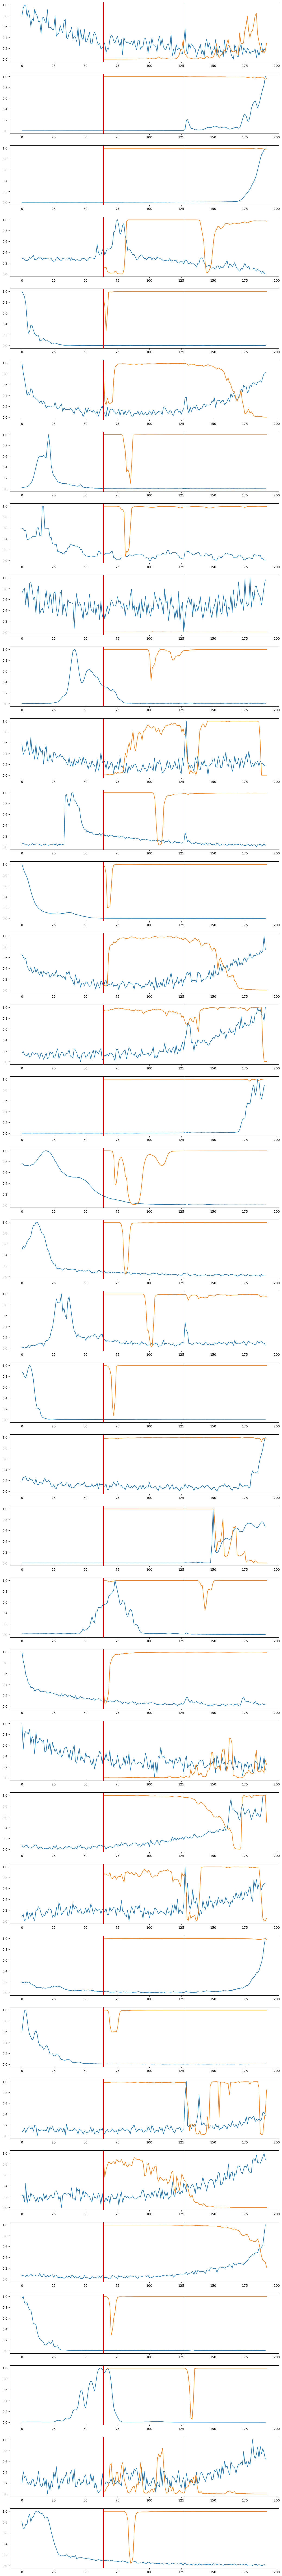

In [25]:
n_grb = len(true_grb)
fig, axs = plt.subplots(n_grb,figsize=(15,4*n_grb))
for i in range(n_grb):
    axs[i].plot(true_grb[i])
    axs[i].plot(xShift,pred[i])
    axs[i].axvline(64,color='red')
    axs[i].axvline(128)

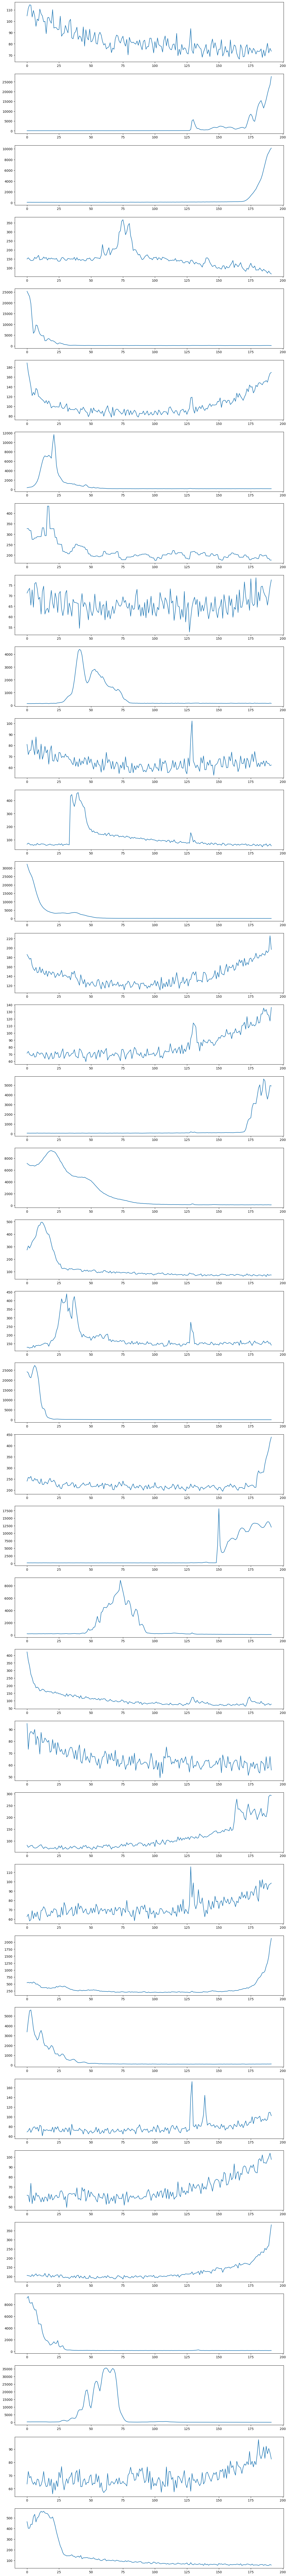

In [26]:
n_grb = len(true_grb)
fig, axs = plt.subplots(n_grb,figsize=(15,4*n_grb))
for i in range(n_grb):
    axs[i].plot(true_nonnorm[i])

In [35]:
def find_peaks_np(r, mu, n_binnings=8, prob_th=1e-5, false_rate=None, ns=None):
    if ns is not None:
        prob_th = norm(0,1).sf(ns)

    threshold = poisson(mu).isf(prob_th)
    return threshold
find_peaks_np(X[0],1)

8.0

In [37]:
X[1]

array([  1,   5,  10,  15,  20,  25,  50, 100, 150, 200, 300, 500])